In [2]:
# importing modules needed

import os
import pandas as pd
import numpy as np
from scipy import stats
import openpyxl
import matplotlib.pyplot as plt
import scipy
from scipy.fftpack import irfft, rfft

%matplotlib inline
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import seaborn as sns

In [3]:
## data will be directly imported from the saved excel file

Data_final = pd.read_excel('MET-EDT-RawData.xlsx')

In [7]:
#Data_final.drop('Unnamed: 0',axis=1,inplace=True)
Data_final.head()
Data = Data_final.copy()

In [9]:
Data_Processed = pd.DataFrame()
sec = 1.2792877225866917
secs = 1.2792877225866917
N = 4096
fs_rate=round(N/sec)
fs_rate
Ts = 1.0/fs_rate # sampling interval in time
t = np.arange(0, secs, Ts) # time vector as scipy arange field / numpy.ndarray
freqs = scipy.fftpack.fftfreq(N, t[1]-t[0])
freqs_side = freqs[range(N//2)] # one side frequency range
## high pass filter
for i,row in Data.iterrows():
    data = row['Vsample1':'Vsample4096'] - row['Vsample1':'Vsample4096'].mean() # subracting mean from the samples
    #print(row["Data_pull_time":"Sensor_Loc"])
    f_signal = rfft(data)
    #print(row['Vsample1':'Vsample6'])
    #print(f_signal[:5])
    #print(len(f_signal))
    #If our original signal time was in seconds, this is now in Hz    
    cut_f_signal = f_signal.copy()
    #cut_f_signal[(freqs<6) & (freqs>-6)] = 0
    data = irfft(cut_f_signal)
    rms = np.sqrt(np.mean(np.array(data)**2))
    kurt=stats.kurtosis(data)
    if rms>.02 and kurt<300 and freqs_side[-1]>1550: ## to keep the range at least 800 hz
        FFT = scipy.fft.fft(data)
        FFT_side = FFT[range(N//2)] # one side FFT range, because we need just the haf of the frequency data because of symmetry
        abs_fft_1=abs(FFT_side)
        
        payload={
                        "Data_pull_time" : row["Data_pull_time"],
                        "Mac_Id" : row["Mac_Id"],
                        "Axis" : row["Axis"],
                        "Defect_Introduced" : row["Defect_Introduced"],
                        "Asset_Id" : row["Asset_Id"],
                        "Sensor_Loc":row["Sensor_Loc"],
                        "peak-peak": (max(data)-min(data)),
                        "rms": rms,
                        "kurt":kurt,
                        "crest":np.max(np.abs(data))/np.sqrt(np.mean(np.square(data))),
                        "variance":np.var(data),
                        "mean":np.mean(data),
                        "skewness":stats.skew(data),
                        'freqAmpliMean':np.mean(abs_fft_1),
                        'freqAmpliMax':max(abs_fft_1),
                        'freqAmpliKurt':stats.kurtosis(abs_fft_1),
                        'freqAmpliskw':stats.skew(abs_fft_1),
                        'freqAmpliVar':np.var(abs_fft_1),
                        }
        lenFreq=len(freqs_side)
        lastFreq=freqs_side[-1]
        abs_fft_1=list(abs_fft_1)
        jj=0
        feqv=1
        while jj < lenFreq and feqv<=8: ## for 8 bins from 0 to 1600 Hz
            #print('Condition satisfied')
            kk=int(round(jj+lenFreq/lastFreq*200)) ## 100 is freqency step size for binnning
            #print(kk)
            fft_Range=abs_fft_1[jj:kk]
            freq_sideRange=freqs_side[jj:kk]
            jj=kk
            payload['max_{}'.format(feqv)]=max(fft_Range)
            payload['mean_{}'.format(feqv)]=np.mean(fft_Range)
            payload['var_{}'.format(feqv)]=np.var(fft_Range)
            feqv+=1
        Data_Processed = Data_Processed.append(payload, ignore_index=True)


### 1.  Feature selection for MET-EDT

In [15]:
Data_Processed.head()

,Asset_Id,Axis,Data_pull_time,Defect_Introduced,Mac_Id,Sensor_Loc,crest,freqAmpliKurt,freqAmpliMax,freqAmpliMean,...,skewness,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,variance
0,101.CA.DTL.01.1-050,X,2020-07-21 12:37:43,No Defect_Empty Tray,29:9c:fe:16,MET_EDT,17.692794,13.104953,102.389972,10.499526,...,0.260243,295.258373,117.998580,64.943508,82.691562,16.019398,3.086827,2.870635,2.164639,0.054294
1,101.CA.DTL.01.1-050,X,2020-07-21 13:32:32,No Defect_Empty Tray,29:9c:fe:16,MET_EDT,6.550334,36.088744,125.279978,7.632612,...,0.013241,143.568690,255.952350,35.103860,89.907245,6.066775,2.207291,1.616244,1.162250,0.038136
2,101.CA.DTL.01.1-050,X,2020-07-21 13:49:25,No Defect_Empty Tray,29:9c:fe:16,MET_EDT,5.147500,90.016390,214.603791,7.944266,...,-0.015044,128.992456,331.357015,41.748621,91.429373,6.852491,1.881266,1.169459,2.149036,0.041601
3,101.CA.DTL.01.1-050,X,2020-07-21 14:15:48,No Defect_Empty Tray,29:9c:fe:16,MET_EDT,6.142973,38.604170,188.883617,10.130518,...,-0.114612,185.879459,779.423070,58.322527,69.898047,7.679959,2.025342,1.674472,1.387360,0.076713
4,101.CA.DTL.01.1-050,X,2020-07-21 15:06:27,No Defect_Empty Tray,29:9c:fe:16,MET_EDT,4.920943,30.354636,182.508059,10.076308,...,0.054166,199.587168,700.936131,42.589595,55.949301,9.088518,1.836583,0.931422,1.177692,0.074345


In [25]:
Data_METEDT = Data_Processed.copy()
Load_NoLoad_group = {"No Defect_No Load": "No_Load",
                     "Non Drive side faulty bearing was introduced - with no tray":"Fault",
                     "No Defect_Empty Tray":"Load",
                     "Decline-Non Drive Side Tesnion unit faulty bearing & Drive side belt removed- with no Tray":"Fault",
                     "non drive side faulty bearing was introduced_with no tray":"Fault",
                     "Drive side belt removed_with no tray":"Fault",
                     "No Defect_with no tray" : "No_Load",
                    "slight wobbling in the motor_No Load": "Fault",
                    "slight wobbling in the motor_Empty Tray":"Fault",
                    "Belt showing signs of wear and tear, slight wobbling in the motor":"Fault"}

Data_METEDT["Actual_Cluster"] = [ Load_NoLoad_group[i] for i in Data_METEDT.Defect_Introduced]

In [19]:
Data_METEDT.columns

Index(['Asset_Id', 'Axis', 'Data_pull_time', 'Defect_Introduced', 'Mac_Id',
       'Sensor_Loc', 'crest', 'freqAmpliKurt', 'freqAmpliMax', 'freqAmpliMean',
       'freqAmpliVar', 'freqAmpliskw', 'kurt', 'max_1', 'max_2', 'max_3',
       'max_4', 'max_5', 'max_6', 'max_7', 'max_8', 'mean', 'mean_1', 'mean_2',
       'mean_3', 'mean_4', 'mean_5', 'mean_6', 'mean_7', 'mean_8', 'peak-peak',
       'rms', 'skewness', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8', 'variance', 'Actual_Cluster'],
      dtype='object')

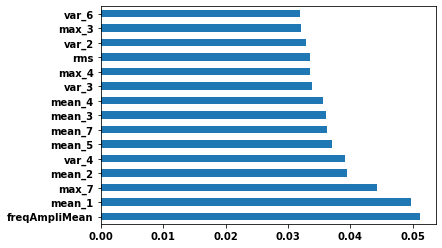

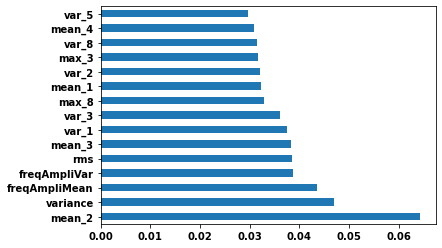

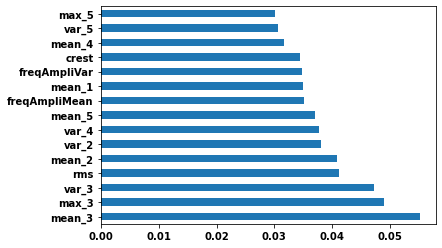

In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

Data_METEDT_X = Data_METEDT[Data_METEDT.Axis == 'X']
Data_METEDT_Y = Data_METEDT[Data_METEDT.Axis == 'Y']
Data_METEDT_Z = Data_METEDT[Data_METEDT.Axis == 'Z']

X = Data_METEDT_X.loc[:,"crest":"variance"]  # independent variables data
y = Data_METEDT_X.Actual_Cluster  # dependednt variable data

model = ExtraTreesClassifier()
model.fit(X,y)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

X = Data_METEDT_Y.loc[:,"crest":"variance"]  # independent variables data
y = Data_METEDT_Y.Actual_Cluster  # dependednt variable data

model = ExtraTreesClassifier()
model.fit(X,y)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

X = Data_METEDT_Z.loc[:,"crest":"variance"]  # independent variables data
y = Data_METEDT_Z.Actual_Cluster  # dependednt variable data

model = ExtraTreesClassifier()
model.fit(X,y)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

### 2. Correlation Matrix with Heatmap

In [29]:
Data_METEDT_F2 = Data_METEDT.copy()

In [31]:
Data_METEDT_F2.Actual_Cluster.value_counts()

Fault      846
No_Load    500
Load       210
Name: Actual_Cluster, dtype: int64

In [32]:
Load_NoLoad_num = {"Fault": 2,
                     "Load":1,
                  "No_Load":0}

Data_METEDT_F2["Load_Fault"] = [ Load_NoLoad_num[i] for i in Data_METEDT_F2.Actual_Cluster]

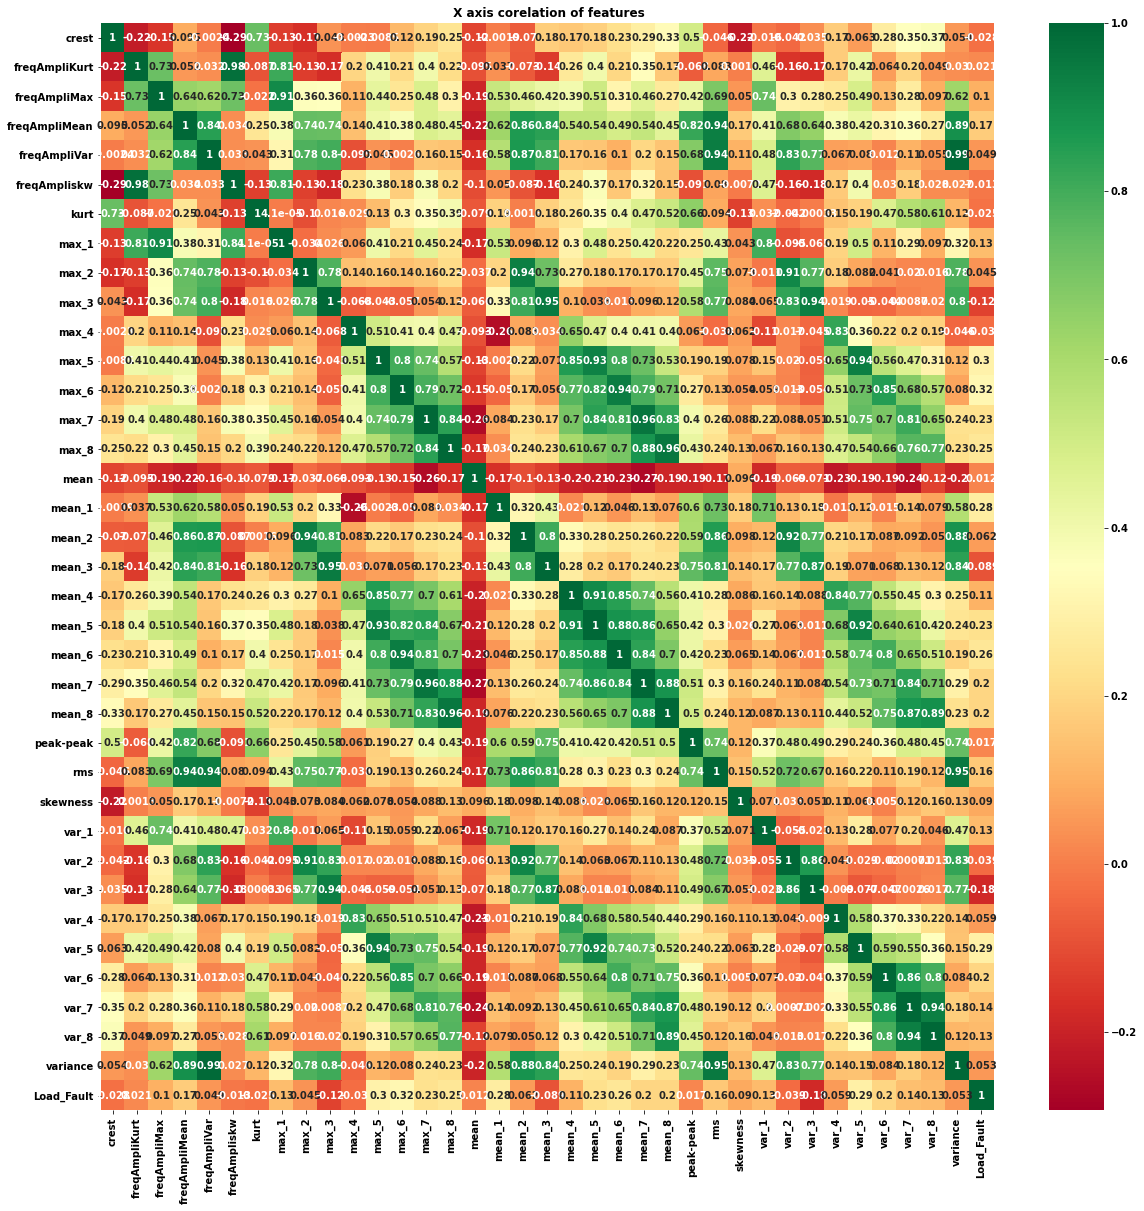

In [44]:
Data_METEDT_F2X = Data_METEDT_F2[Data_METEDT_F2.Axis == 'X'] # Change here 

import seaborn as sns
#get correlations of each features in dataset
corrmat = Data_METEDT_F2X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
plt.title(' X axis corelation of features')
#plot heat map
g=sns.heatmap(Data_METEDT_F2X[top_corr_features].corr(),annot=True,cmap="RdYlGn")
#plt.savefig('MET-EDT-X-AXIS-Corelation.png')